# DNN + Equação Linear Aproximada para fR,1 
Treina uma DNN e gera uma equação linear aproximada em **unidades originais**, para previsões interpretáveis.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. CARREGAR OS DADOS
df_temp = pd.read_excel("teste banco de dados.xlsx", header=None)
header_row = df_temp[df_temp.apply(lambda x: x.astype(str).str.contains("Tipo do concreto", case=False, na=False)).any(axis=1)].index[0]
df = pd.read_excel("teste banco de dados.xlsx", header=header_row)
df = df.dropna(axis=1, how="all")

In [2]:
# 2. DEFINIR FEATURES E TARGET
feature_cols = [
    'fck (resistência)            [MPa]',
    'l (comprimento)            [mm]',
    'd (diâmetro            [mm]',
    'l/d      (fator de forma             ',
    'Teor de fibra (%)',
    'N (ganchos)'
]
target_col = 'fR,1 (N/mm²)      (experimental)'

X = df[feature_cols].values
y = df[target_col].values

# 3. DIVIDIR TREINO/TESTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. NORMALIZAR DADOS PARA TREINAMENTO DNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
# 5. TREINAR DNN
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=200, batch_size=16, verbose=1)

# Avaliar DNN
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"DNN - MAE: {mae:.4f}, Loss (MSE): {loss:.4f}")

Epoch 1/200


C:\Users\carlos.ramos\scoop\apps\python310\current\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 34.5583 - mae: 5.2167 - val_loss: 28.8284 - val_mae: 4.6732
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 25.6008 - mae: 4.3158 - val_loss: 21.8716 - val_mae: 3.8350
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 17.3152 - mae: 3.3428 - val_loss: 15.2442 - val_mae: 3.1172
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.3753 - mae: 2.5277 - val_loss: 10.6075 - val_mae: 2.6047
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.4215 - mae: 2.0624 - val_loss: 8.5941 - val_mae: 2.3910
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3016 - mae: 1.6803 - val_loss: 7.5658 - val_mae: 2.2796
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9251 - mae: 1.6300 - val_loss: 6.6545 - val_mae: 2.1455
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7324 - mae: 1.4647 - val_loss: 5.9467 - val_mae: 2.0200
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9586 

In [4]:
# 6. GERAR PREVISÕES DA DNN PARA TODO DATASET (unidades originais)
X_scaled_full = scaler.transform(X)
y_pred_dnn_full = model.predict(X_scaled_full).flatten()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [5]:
# 7. TREINAR REGRESSÃO LINEAR SOBRE AS PREVISÕES DA DNN (unidades originais)
lin_approx = LinearRegression()
lin_approx.fit(X, y_pred_dnn_full)

intercept_approx = lin_approx.intercept_
coefs_approx = lin_approx.coef_

# Criar string legível da equação
equacao_str = f"fR = {intercept_approx:.5f}"
for c, f in zip(coefs_approx, feature_cols):
    equacao_str += f" + ({c:.5f} * {f})"

print("Equação linear aproximada da DNN (unidades originais):")
print(equacao_str)

Equação linear aproximada da DNN (unidades originais):
fR = -3.03245 + (0.07189 * fck (resistência)            [MPa]) + (0.01149 * l (comprimento)            [mm]) + (-1.00375 * d (diâmetro            [mm]) + (0.01804 * l/d      (fator de forma             ) + (6.20198 * Teor de fibra (%)) + (0.33477 * N (ganchos))


In [6]:
# 8. FUNÇÃO PARA CALCULAR fR COM EQUAÇÃO LINEAR APROXIMADA (unidades originais)
def calcular_fr(**kwargs):
    vals = np.array([kwargs[f] for f in feature_cols])
    return float(intercept_approx + np.dot(coefs_approx, vals))

print('Função calcular_fr habilitada.')

Função calcular_fr habilitada.


In [7]:
# 9. TESTAR EXEMPLO
valores_exemplo = {
    'fck (resistência)            [MPa]': 61.3,
    'l (comprimento)            [mm]': 35,
    'd (diâmetro            [mm]': 0.55,
    'l/d      (fator de forma             ': 63.64,
    'Teor de fibra (%)': 0.4,
    'N (ganchos)': 1
}
fR_previsto = calcular_fr(**valores_exemplo)
print(f'Valor previsto de fR = {fR_previsto:.4f}')

Valor previsto de fR = 5.1882


In [8]:
# 10. APLICAR A EQUAÇÃO EM TODO DATASET E COMPARAR
preds_approx = np.array([calcular_fr(**{f: row[f] for f in feature_cols}) for idx, row in df.iterrows()])

comparacao = df.copy()
comparacao['fR_previsto'] = preds_approx
print(comparacao[[target_col, 'fR_previsto']].head(10))

mse = mean_squared_error(df[target_col].values, preds_approx)
mae = mean_absolute_error(df[target_col].values, preds_approx)
r2 = r2_score(df[target_col].values, preds_approx)

print(f"\nMSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

   fR,1 (N/mm²)      (experimental)  fR_previsto
0                              4.99     5.188221
1                              7.44     7.848726
2                              5.35     5.344256
3                              7.94     7.472808
4                              5.49     5.188221
5                              4.37     5.188221
6                              4.67     5.188221
7                              5.22     5.188221
8                              4.74     5.188221
9                              5.46     5.188221

MSE: 1.4725
MAE: 0.8996
R²: 0.7775


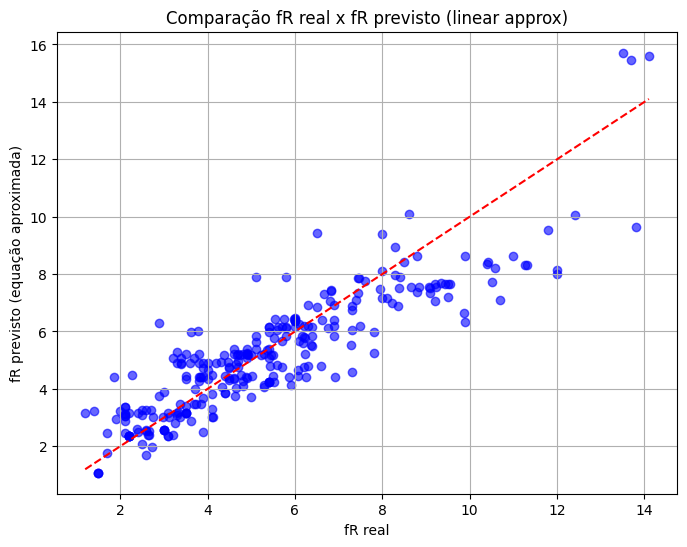

In [9]:
# 11. GRÁFICO fR REAL X fR PREVISTO
plt.figure(figsize=(8,6))
plt.scatter(df[target_col].values, preds_approx, alpha=0.6, color='blue')
plt.plot([df[target_col].min(), df[target_col].max()], [df[target_col].min(), df[target_col].max()], 'r--')
plt.xlabel('fR real')
plt.ylabel('fR previsto (equação aproximada)')
plt.title('Comparação fR real x fR previsto (linear approx)')
plt.grid(True)
plt.show()

Comparação com erro absoluto:
   fR,1 (N/mm²)      (experimental)  fR_previsto  Erro_absoluto
0                              4.99     5.188221       0.198221
1                              7.44     7.848726       0.408726
2                              5.35     5.344256       0.005744
3                              7.94     7.472808       0.467192
4                              5.49     5.188221       0.301779
5                              4.37     5.188221       0.818221
6                              4.67     5.188221       0.518221
7                              5.22     5.188221       0.031779
8                              4.74     5.188221       0.448221
9                              5.46     5.188221       0.271779

Estatísticas do erro absoluto:
count    281.000000
mean       0.899648
std        0.815795
min        0.005744
25%        0.314211
50%        0.621795
75%        1.274195
max        4.146076
Name: Erro_absoluto, dtype: float64


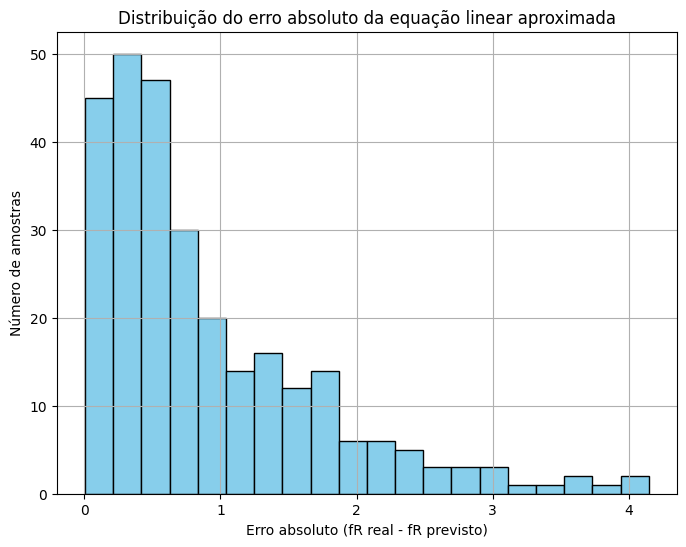

In [10]:
# 12. AVALIAÇÃO DETALHADA DO ERRO POR LINHA

# Calcular erro absoluto por linha
comparacao['Erro_absoluto'] = np.abs(comparacao[target_col] - comparacao['fR_previsto'])

# Mostrar as primeiras 10 linhas com erro
print("Comparação com erro absoluto:")
print(comparacao[[target_col, 'fR_previsto', 'Erro_absoluto']].head(10))

# Estatísticas gerais do erro
print("\nEstatísticas do erro absoluto:")
print(comparacao['Erro_absoluto'].describe())

# Plotar histograma do erro absoluto
plt.figure(figsize=(8,6))
plt.hist(comparacao['Erro_absoluto'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Erro absoluto (fR real - fR previsto)')
plt.ylabel('Número de amostras')
plt.title('Distribuição do erro absoluto da equação linear aproximada')
plt.grid(True)
plt.show()


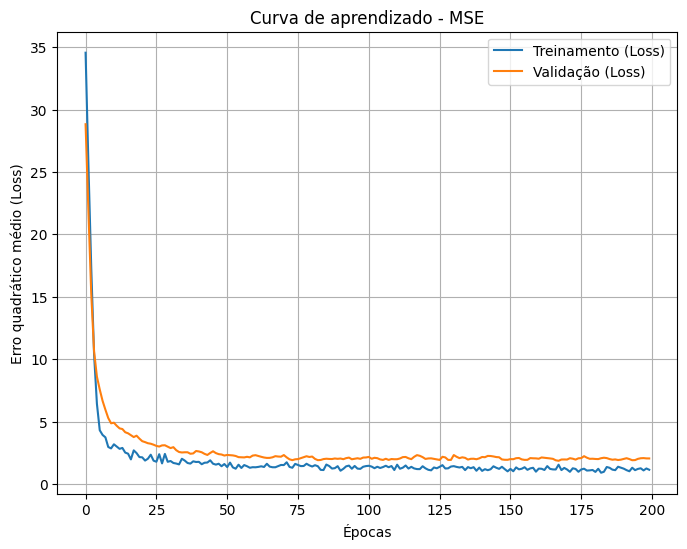

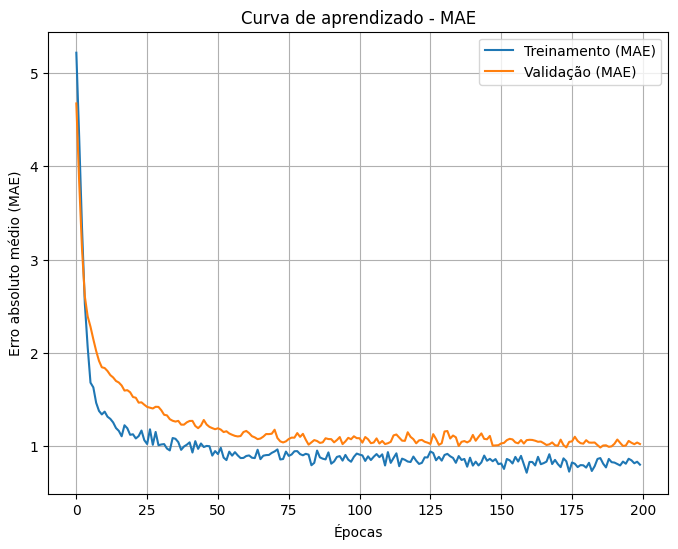

In [11]:
# 13. CURVAS DE TREINAMENTO DA DNN

import matplotlib.pyplot as plt

# Curva de aprendizado - Loss (MSE)
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Treinamento (Loss)')
plt.plot(history.history['val_loss'], label='Validação (Loss)')
plt.title('Curva de aprendizado - MSE')
plt.xlabel('Épocas')
plt.ylabel('Erro quadrático médio (Loss)')
plt.legend()
plt.grid(True)
plt.show()

# Curva de aprendizado - MAE
plt.figure(figsize=(8,6))
plt.plot(history.history['mae'], label='Treinamento (MAE)')
plt.plot(history.history['val_mae'], label='Validação (MAE)')
plt.title('Curva de aprendizado - MAE')
plt.xlabel('Épocas')
plt.ylabel('Erro absoluto médio (MAE)')
plt.legend()
plt.grid(True)
plt.show()
